In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/subset_fixed.zip -d .


Archive:  /content/drive/MyDrive/subset_fixed.zip
   creating: ./subset_fixed/
   creating: ./subset_fixed/test/
   creating: ./subset_fixed/test/IR_drop/
  inflating: ./subset_fixed/test/IR_drop/RISCY-FPU_freq_500_mp_3_fpu_75_fpa_2.0_p_0_fi_ap.npy  
  inflating: ./subset_fixed/test/IR_drop/RISCY-FPU_freq_50_mp_1_fpu_65_fpa_1.0_p_3_fi_ar.npy  
  inflating: ./subset_fixed/test/IR_drop/RISCY_freq_200_mp_2_fpu_75_fpa_1.0_p_1_fi_ap.npy  
  inflating: ./subset_fixed/test/IR_drop/RISCY_freq_200_mp_3_fpu_65_fpa_1.5_p_1_fi_ap.npy  
  inflating: ./subset_fixed/test/IR_drop/RISCY_freq_500_mp_2_fpu_60_fpa_1.5_p_4_fi_ap.npy  
  inflating: ./subset_fixed/test/IR_drop/RISCY_freq_500_mp_3_fpu_55_fpa_1.5_p_5_fi_ap.npy  
  inflating: ./subset_fixed/test/IR_drop/RISCY_freq_50_mp_1_fpu_60_fpa_2.0_p_7_fi_ar.npy  
  inflating: ./subset_fixed/test/IR_drop/RISCY_freq_50_mp_4_fpu_55_fpa_1.0_p_6_fi_ar.npy  
  inflating: ./subset_fixed/test/IR_drop/zero-riscy_freq_200_mp_3_fpu_75_fpa_1.0_p_2_fi_ar.npy  
  infla

In [3]:
import os
import random
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


TRAIN_PATH = "subset_fixed/train"
TEST_PATH  = "subset_fixed/test"
CKPT_PATH  = "irdropnet_unet_sharp.pth"
DEVICE     = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 1
LR         = 1e-4
EPOCHS     = 50
GRAD_WEIGHT = 0.1  # Enough to sharpen edges, low enough to prevent noise

print(f"Running on Device: {DEVICE}")

Running on Device: cuda


In [4]:
#preprocess data
def resize_map(img):
    return cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

def min_max_norm(img):
    if img.max() == 0:
        return img
    return (img - img.min()) / (img.max() - img.min())

def process_label(label_raw):
    label = np.squeeze(label_raw)
    label = np.clip(label, 1e-6, 50)
    label = resize_map(label)
    label = (np.log10(label) + 6) / (np.log10(50) + 6)
    return label[None, ...]

class IRDropDataset(Dataset):
    def __init__(self, base_path):
        base_path = Path(base_path)
        self.label_dir = base_path / "IR_drop"
        self.power_t_dir = base_path / "power_t"
        self.power2d_dirs = [
            base_path / "power_i",
            base_path / "power_s",
            base_path / "power_sca",
            base_path / "power_all",
        ]
        self.files = sorted([p.name for p in self.label_dir.glob("*.npy")])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        spatial_maps = []
        for d in self.power2d_dirs:
            arr = np.load(d / fname)
            arr = min_max_norm(resize_map(arr))
            spatial_maps.append(arr)
        spatial_maps = np.stack(spatial_maps, axis=0)

        power_t = np.load(self.power_t_dir / fname)
        processed_slices = []
        for i in range(power_t.shape[0]):
            slice_img = power_t[i, :, :]
            slice_proc = min_max_norm(resize_map(slice_img))
            processed_slices.append(slice_proc)
        power_t = np.stack(processed_slices, axis=0)
        power_t = power_t[None, ...]

        label_raw = np.load(self.label_dir / fname)
        label = process_label(label_raw)

        return (
            torch.tensor(spatial_maps, dtype=torch.float32),
            torch.tensor(power_t, dtype=torch.float32),
            torch.tensor(label, dtype=torch.float32)
        )

In [5]:
class GradientDifferenceLoss(nn.Module):
    def __init__(self):
        super(GradientDifferenceLoss, self).__init__()

    def forward(self, pred, target):
        pred_dx = torch.abs(pred[:, :, :, :-1] - pred[:, :, :, 1:])
        target_dx = torch.abs(target[:, :, :, :-1] - target[:, :, :, 1:])
        pred_dy = torch.abs(pred[:, :, :-1, :] - pred[:, :, 1:, :])
        target_dy = torch.abs(target[:, :, :-1, :] - target[:, :, 1:, :])

        return torch.mean(torch.abs(pred_dx - target_dx)) + torch.mean(torch.abs(pred_dy - target_dy))

In [6]:
class DoubleConv2d(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.net(x)

class Down2d(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(nn.MaxPool2d(2), DoubleConv2d(in_ch, out_ch))
    def forward(self, x): return self.net(x)

class Up2d(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = DoubleConv2d(in_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            x = F.interpolate(x, size=skip.shape[-2:], mode='bilinear', align_corners=False)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class TemporalEncoder3D(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(in_ch, 8, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool3d((2,2,2)))
        self.conv2 = nn.Sequential(nn.Conv3d(8,16,3,padding=1), nn.ReLU(inplace=True), nn.MaxPool3d((2,2,2)), nn.AdaptiveAvgPool3d((1, None, None)))
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x.squeeze(2)

class IRDropUNet(nn.Module):
    def __init__(self, in_spatial_ch=4, temporal_ch=1, base=32):
        super().__init__()
        # Encoder
        self.inc = DoubleConv2d(in_spatial_ch, base)
        self.down1 = Down2d(base, base*2)
        self.down2 = Down2d(base*2, base*4)

        # Temporal
        self.temporal = TemporalEncoder3D(in_ch=temporal_ch)
        self.temp_proj = nn.Conv2d(16, base*4, kernel_size=1)

        # Decoder
        self.up1 = Up2d(base * 10, base * 2)
        self.up2 = Up2d(base * 3, base)
        self.outc = nn.Conv2d(base, 1, kernel_size=1)

    def forward(self, spatial_x, temporal_x, label_shape=None):
        x1 = self.inc(spatial_x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        t = self.temporal(temporal_x)
        t_proj = self.temp_proj(t)

        bottleneck = torch.cat([x3, t_proj], dim=1)
        u1 = self.up1(bottleneck, x2)
        u2 = self.up2(u1, x1)
        out = self.outc(u2)

        if label_shape is not None:
            out = F.interpolate(out, size=label_shape[-2:], mode='bilinear', align_corners=False)
        return out

In [7]:
#training loop
train_ds = IRDropDataset(TRAIN_PATH)
test_ds  = IRDropDataset(TEST_PATH)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False)


model = IRDropUNet(in_spatial_ch=4, temporal_ch=1, base=32).to(DEVICE)

criterion_mae = nn.L1Loss()
criterion_grad = GradientDifferenceLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f"Starting Standard U-Net + Sharpness (Grad Weight: {GRAD_WEIGHT})...")

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0

    for i, (spatial, temporal, label) in enumerate(train_loader):
        spatial = spatial.to(DEVICE)
        temporal = temporal.to(DEVICE)
        label = label.to(DEVICE)

        optimizer.zero_grad()
        pred = model(spatial, temporal, label_shape=label.shape)

        loss_mae = criterion_mae(pred, label)
        loss_grad = criterion_grad(pred, label)

        # Balanced Loss: Mostly MAE, small Grad penalty
        total_loss = loss_mae + (GRAD_WEIGHT * loss_grad)

        total_loss.backward()
        optimizer.step()
        running_loss += loss_mae.item() # Track MAE

    avg = running_loss / len(train_loader)
    print(f"Epoch {epoch}/{EPOCHS} - Train MAE: {avg:.6f}")

    if epoch % 5 == 0 or epoch == EPOCHS:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for spatial, temporal, label in test_loader:
                spatial = spatial.to(DEVICE)
                temporal = temporal.to(DEVICE)
                label = label.to(DEVICE)
                pred = model(spatial, temporal, label_shape=label.shape)
                val_loss += criterion_mae(pred, label).item()
        print(f"  >>> VAL MAE: {val_loss / len(test_loader):.6f}")

torch.save(model.state_dict(), CKPT_PATH)
print("Training Complete.")



Starting Standard U-Net + Sharpness (Grad Weight: 0.1)...
Epoch 1/50 - Train MAE: 0.506995
Epoch 2/50 - Train MAE: 0.279189
Epoch 3/50 - Train MAE: 0.205536
Epoch 4/50 - Train MAE: 0.168862
Epoch 5/50 - Train MAE: 0.150766
  >>> VAL MAE: 0.123924
Epoch 6/50 - Train MAE: 0.139404
Epoch 7/50 - Train MAE: 0.134594
Epoch 8/50 - Train MAE: 0.133559
Epoch 9/50 - Train MAE: 0.129194
Epoch 10/50 - Train MAE: 0.126327
  >>> VAL MAE: 0.103470
Epoch 11/50 - Train MAE: 0.121934
Epoch 12/50 - Train MAE: 0.118144
Epoch 13/50 - Train MAE: 0.117109
Epoch 14/50 - Train MAE: 0.113150
Epoch 15/50 - Train MAE: 0.111549
  >>> VAL MAE: 0.182108
Epoch 16/50 - Train MAE: 0.110078
Epoch 17/50 - Train MAE: 0.110768
Epoch 18/50 - Train MAE: 0.108650
Epoch 19/50 - Train MAE: 0.106345
Epoch 20/50 - Train MAE: 0.105137
  >>> VAL MAE: 0.131483
Epoch 21/50 - Train MAE: 0.104551
Epoch 22/50 - Train MAE: 0.104103
Epoch 23/50 - Train MAE: 0.104696
Epoch 24/50 - Train MAE: 0.102193
Epoch 25/50 - Train MAE: 0.101137
  >>>

Displaying first 10 test samples...


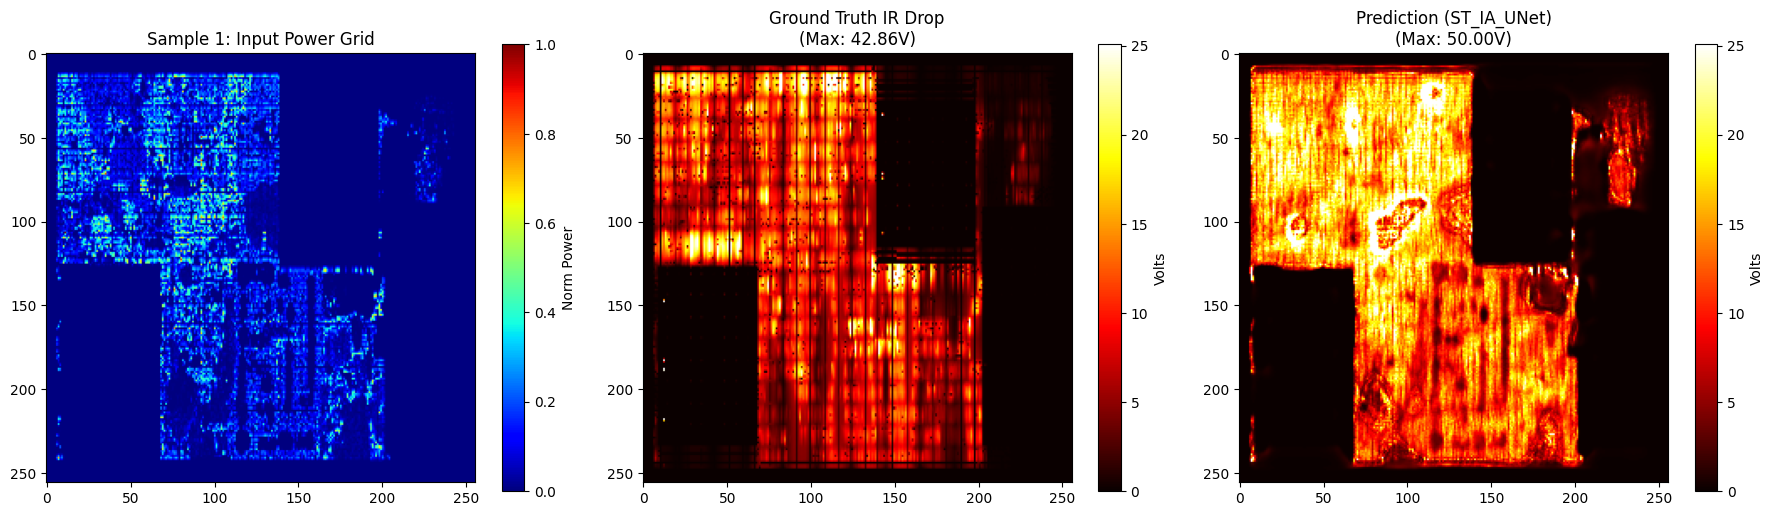

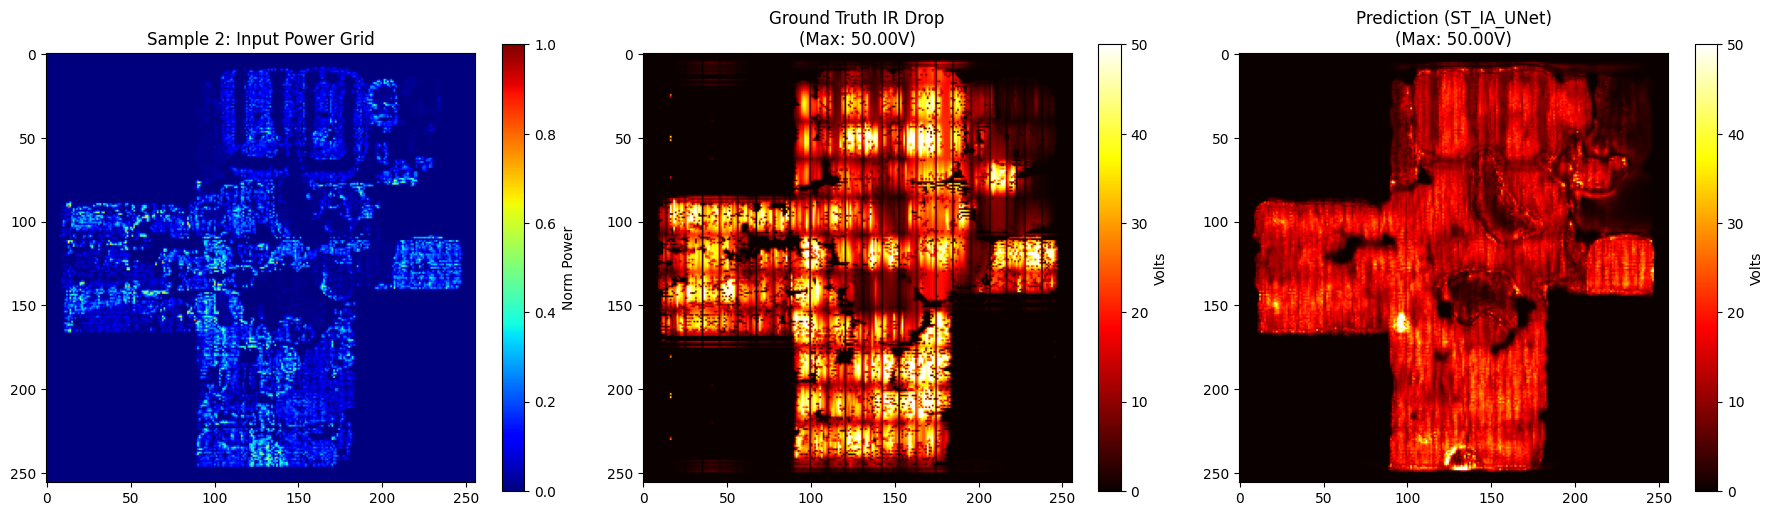

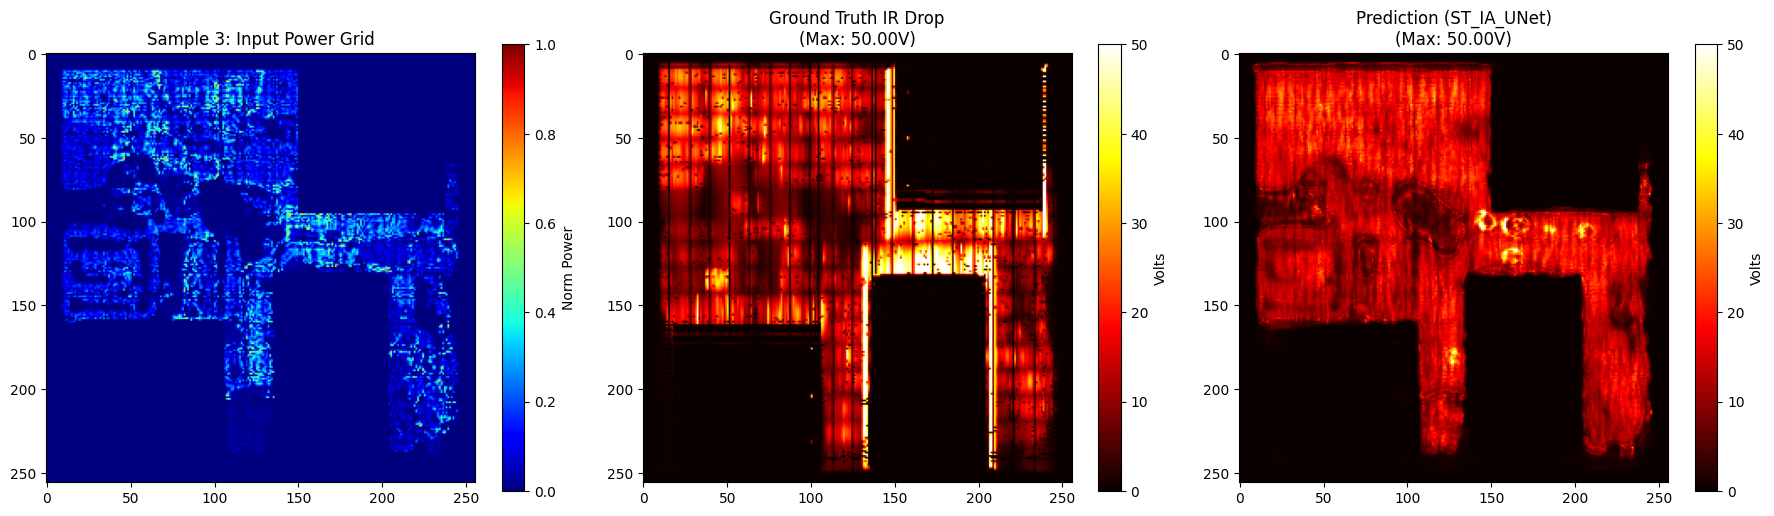

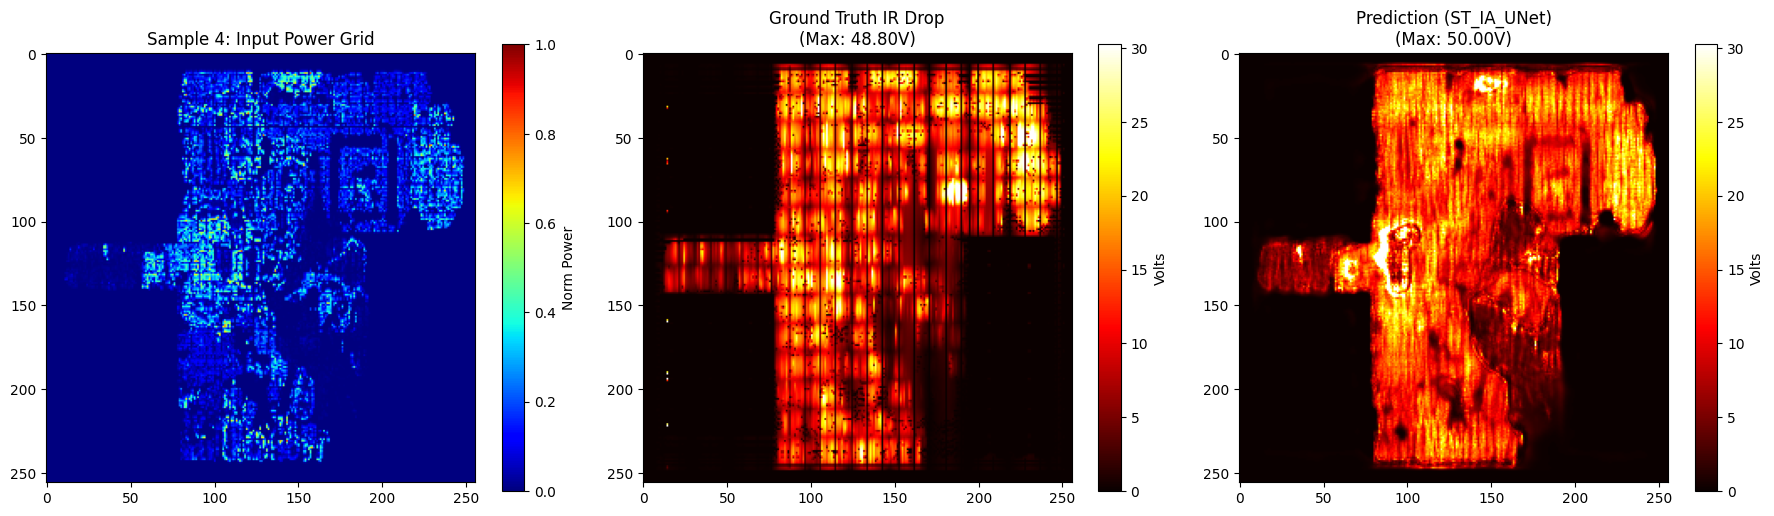

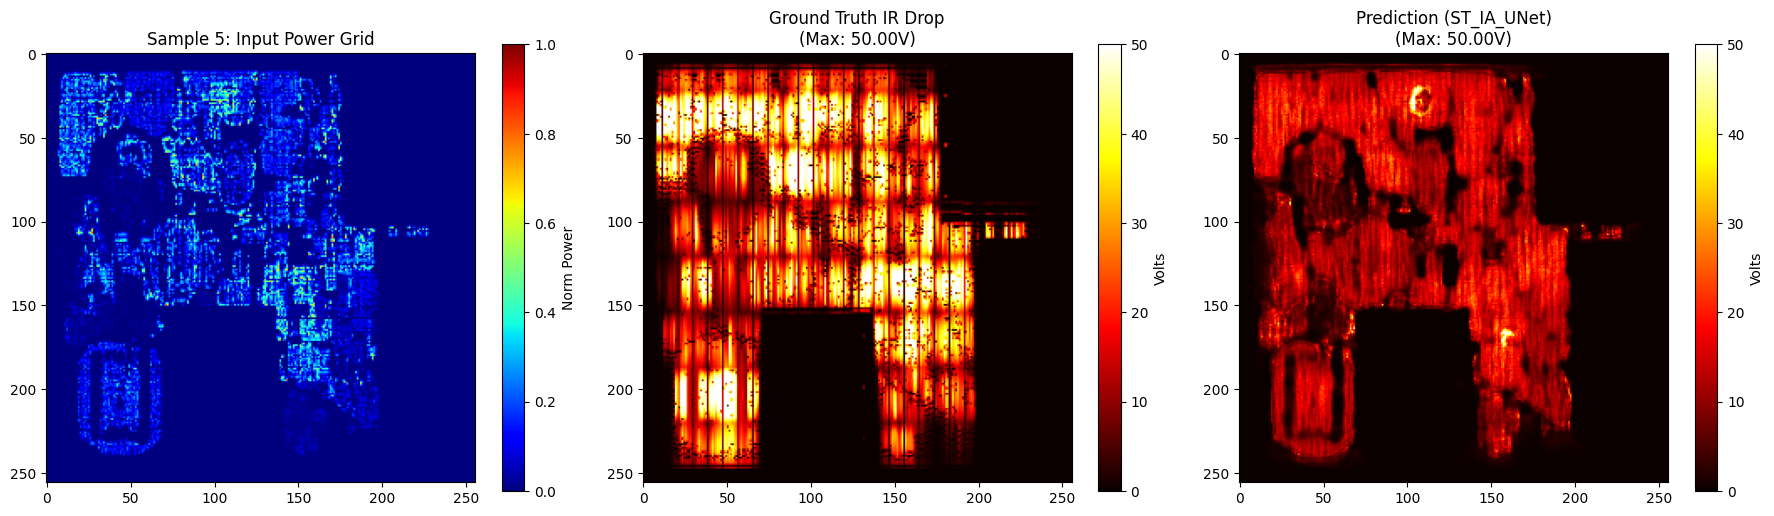

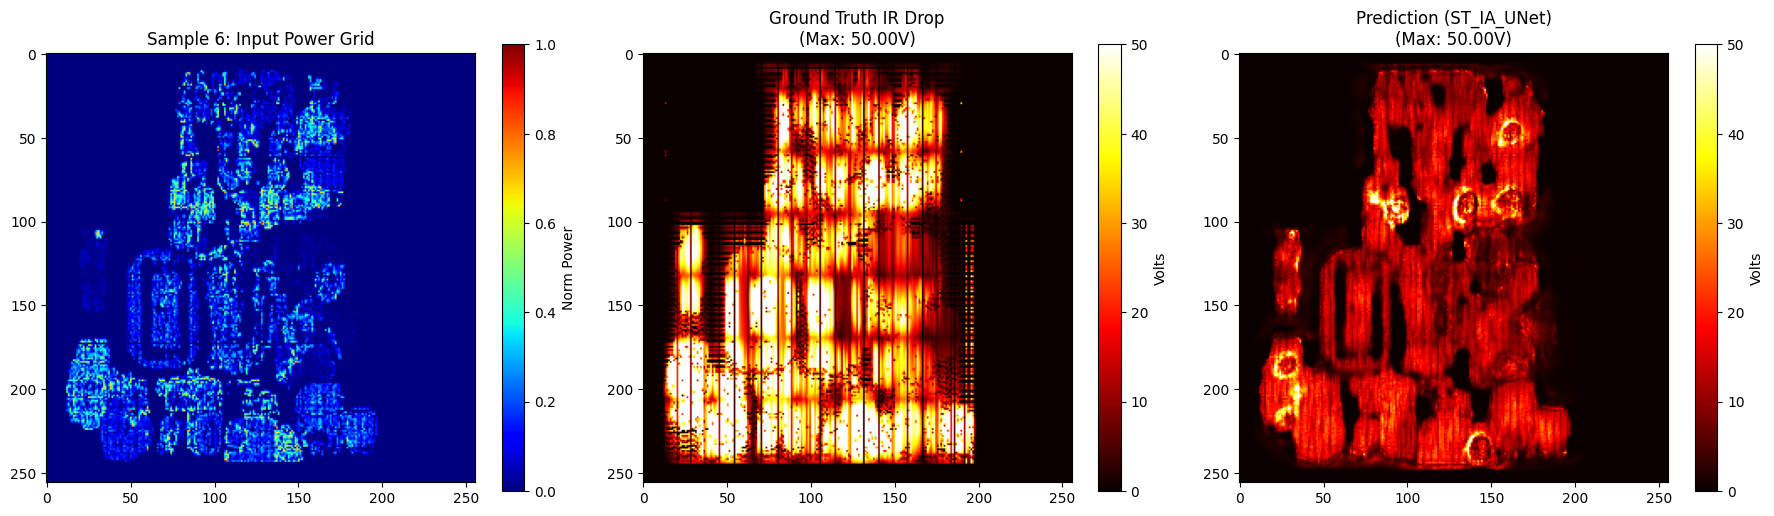

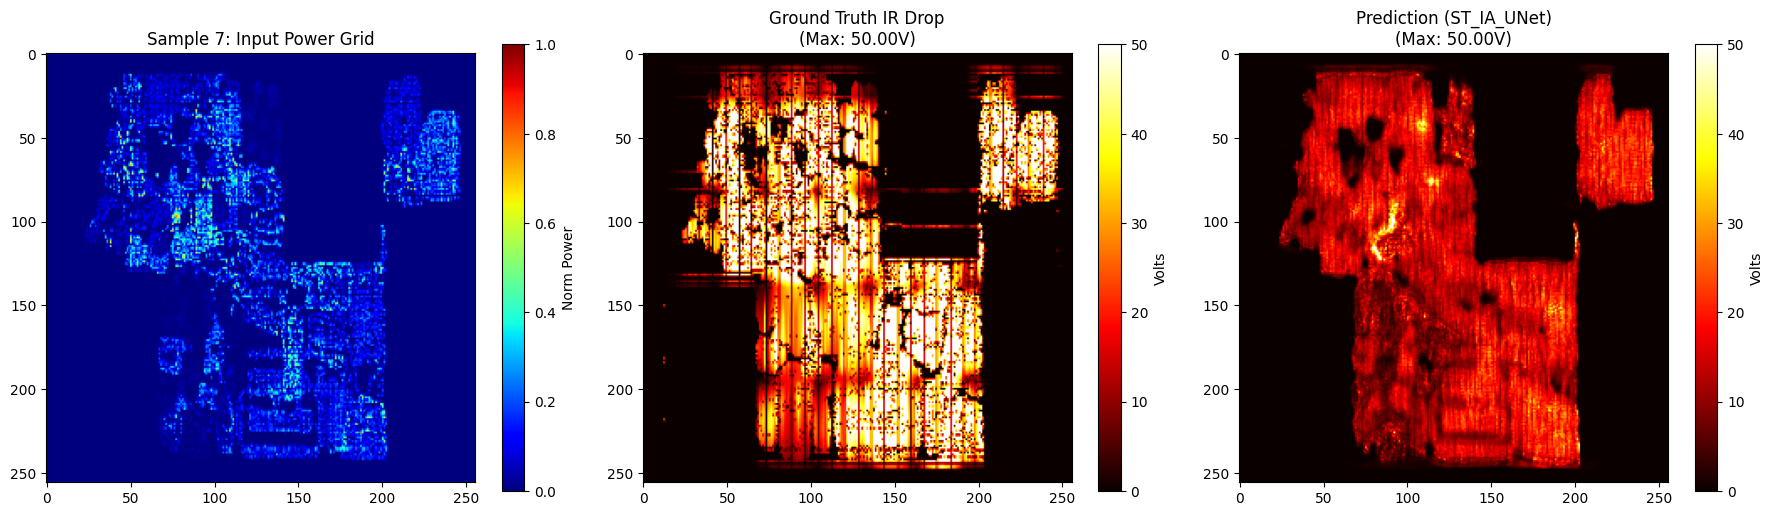

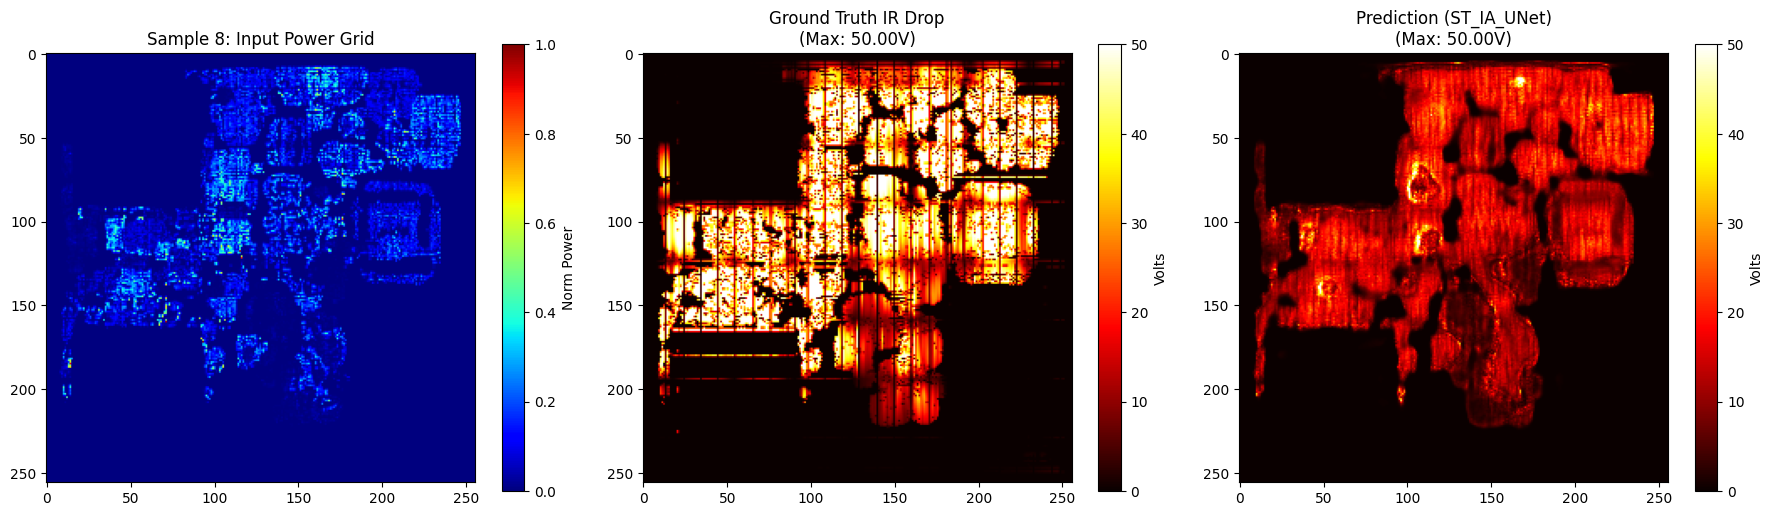

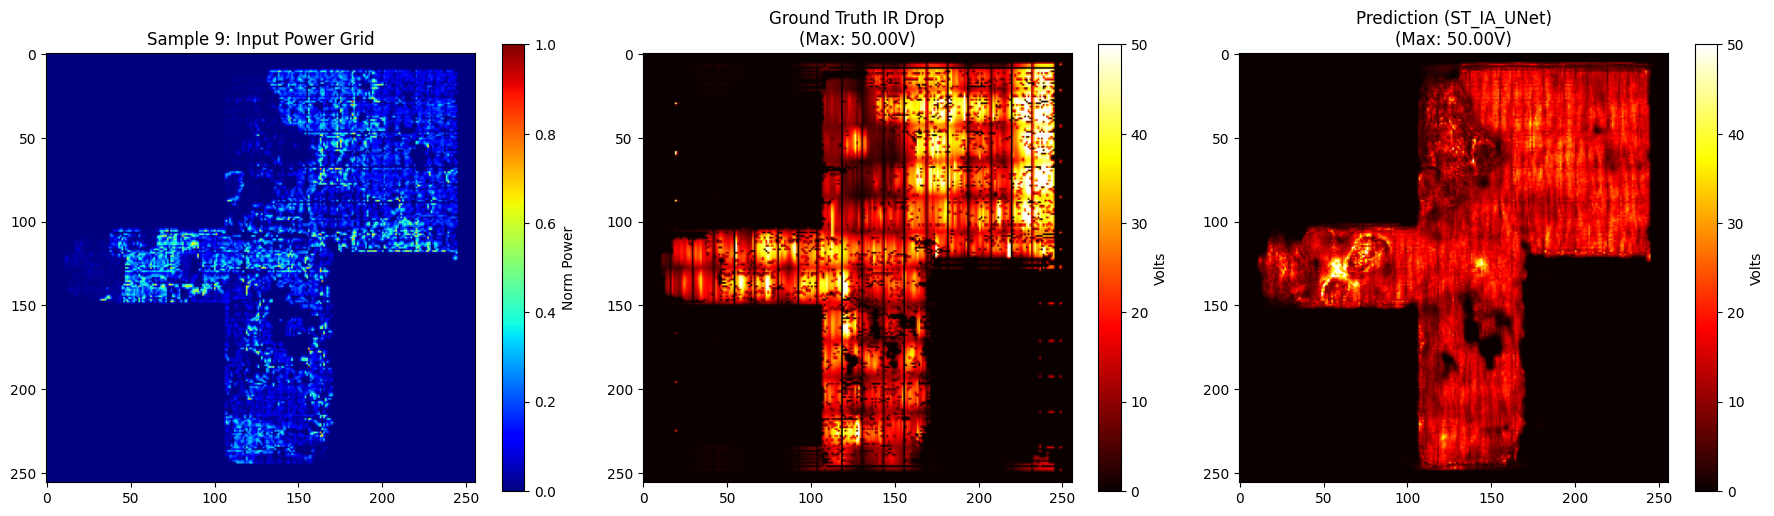

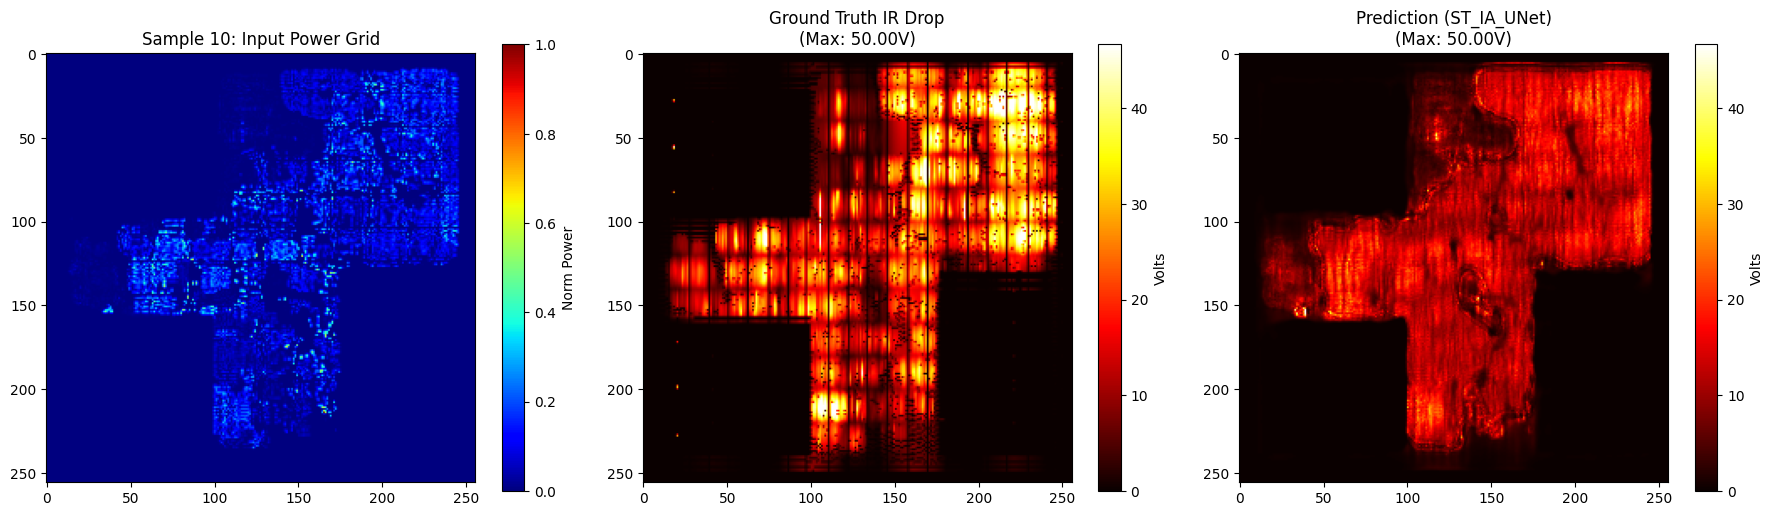

In [14]:
import matplotlib.pyplot as plt
import numpy as np

NUM_SAMPLES_TO_SHOW = 10

# (Log Space -> Real Volts)
def denormalize_ir_drop(val_norm):
    """Reverses: val_norm = (log10(x) + 6) / (log10(50) + 6)"""
    DENOM = np.log10(50) + 6
    log_val = (val_norm * DENOM) - 6
    return np.power(10, log_val)

model.eval()

print(f"Displaying first {NUM_SAMPLES_TO_SHOW} test samples...")

for i, (spatial, temporal, label) in enumerate(test_loader):
    if i >= NUM_SAMPLES_TO_SHOW:
        break

    spatial = spatial.to(DEVICE)
    temporal = temporal.to(DEVICE)
    label = label.to(DEVICE)

    with torch.no_grad():
        pred = model(spatial, temporal, label_shape=label.shape)

    spatial_np = spatial[0,0].cpu().numpy()
    label_np   = label[0,0].cpu().numpy()
    pred_np    = pred[0,0].cpu().numpy()

    # Denormalize to Real Volts
    label_real = denormalize_ir_drop(label_np)
    pred_real  = denormalize_ir_drop(pred_np)

    # Clamps prediction to realistic range (0V to 50V)
    # This removes the "641V" outliers caused by log-inverse sensitivity
    pred_real = np.clip(pred_real, 0, 50)

    # Robust Scaling: Use 99.5th percentile of Ground Truth to ignore visual outliers
    vmax = np.percentile(label_real, 99.5)
    if vmax == 0: vmax = 1.0 # Safety check

    plt.figure(figsize=(18, 5))

    # Input Power
    plt.subplot(1, 3, 1)
    plt.title(f"Sample {i+1}: Input Power Grid")
    plt.imshow(spatial_np, cmap='jet')
    plt.colorbar(label="Norm Power")

    # Ground Truth
    plt.subplot(1, 3, 2)
    plt.title(f"Ground Truth IR Drop\n(Max: {label_real.max():.2f}V)")
    plt.imshow(label_real, cmap='hot', vmin=0, vmax=vmax)
    plt.colorbar(label="Volts")

    # Prediction
    plt.subplot(1, 3, 3)
    plt.title(f"Prediction (ST_IA_UNet)\n(Max: {pred_real.max():.2f}V)")
    plt.imshow(pred_real, cmap='hot', vmin=0, vmax=vmax)
    plt.colorbar(label="Volts")

    plt.tight_layout()
    plt.show()

In [9]:
model.eval()
total_mae_volts = 0.0
count = 0

print("Calculating final accuracy on the full test set...")

with torch.no_grad():
    for spatial, temporal, label in test_loader:
        spatial = spatial.to(DEVICE)
        temporal = temporal.to(DEVICE)
        label = label.to(DEVICE)

        pred = model(spatial, temporal, label_shape=label.shape)
        label_np = label.cpu().numpy()
        pred_np = pred.cpu().numpy()

        # "Un-squash" the data (Log -> Real Volts)
        label_real = denormalize_ir_drop(label_np)
        pred_real = denormalize_ir_drop(pred_np)

        # Clip outliers
        pred_real = np.clip(pred_real, 0, 50)

        mask = label_real > 0.01
        if mask.sum() > 0:
            mae = np.mean(np.abs(pred_real[mask] - label_real[mask]))
            total_mae_volts += mae
            count += 1

final_mae = total_mae_volts / count
print(f"\n==============================================")
print(f"FINAL TEST RESULT: Average Error = {final_mae:.4f} Volts")
print(f"==============================================")


Calculating final accuracy on the full test set...

FINAL TEST RESULT: Average Error = 9.7491 Volts
